In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data2 = pd.read_csv('/content/DATASET_FINAL.csv')
data2 = data2.drop('Unnamed: 0', axis=1)

In [3]:
data2['Date'] = data2['Date'].apply(lambda x: pd.to_datetime(x))
data2.drop([8224])
data2=data2.iloc[::-1]
data2 = data2.reset_index().drop('index', axis=1)
data2 = data2.fillna(0)
data2 = data2[['Date', 'Price']]

In [4]:
data2

,Date,Price
0,2001-03-23,25.38
1,2001-03-22,24.63
2,2001-03-22,24.63
3,2001-03-22,24.63
4,2001-03-21,25.00
...,...,...
11118,1988-06-05,14.85
11119,1988-06-04,14.85
11120,1988-06-03,14.85
11121,1988-06-02,14.85


In [5]:
pip install catboost

     |████████████████████████████████| 65.7MB 46kB/s 


In [6]:
data2['Price_ND']=data2['Price'].shift(-1)
for i in range(1,32):
    data2['Price_LD_{}'.format(i)]=data2['Price'].shift(i)
autoreg_columns = ['Price_LD_{}'.format(i) for i in range(1, 16)]

In [7]:
data2['moving_mean_all_autoreg'] = data2[autoreg_columns].mean(axis=1)
data2['moving_std_all_autoreg'] = data2[autoreg_columns].std(axis=1)
data2['moving_min_all_autoreg'] = data2[autoreg_columns].min(axis=1)
data2['moving_max_all_autoreg'] = data2[autoreg_columns].max(axis=1)

In [8]:
data2 = data2.dropna(subset=['Price_ND'], axis=0)

In [10]:
data2.head()

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,Price_LD_16,Price_LD_17,Price_LD_18,Price_LD_19,Price_LD_20,Price_LD_21,Price_LD_22,Price_LD_23,Price_LD_24,Price_LD_25,Price_LD_26,Price_LD_27,Price_LD_28,Price_LD_29,Price_LD_30,Price_LD_31,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,2001-03-23,25.38,24.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-03-22,24.63,24.63,25.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.3800,NaN,25.38,25.38
2,2001-03-22,24.63,24.63,24.63,25.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0050,0.530330,24.63,25.38
3,2001-03-22,24.63,25.00,24.63,24.63,25.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.8800,0.433013,24.63,25.38
4,2001-03-21,25.00,25.00,24.63,24.63,24.63,25.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.8175,0.375000,24.63,25.38


In [11]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [13]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data2.drop(['Date','Price_ND'], axis=1), data2['Price_ND'], test_size=0.3, shuffle=False)

In [15]:
cat = CatBoostRegressor(depth=7)

cat.fit(X_train, y_train, eval_set=(X_test, y_test), silent=True)

No handles with labels found to put in legend.


1.4206152359796962


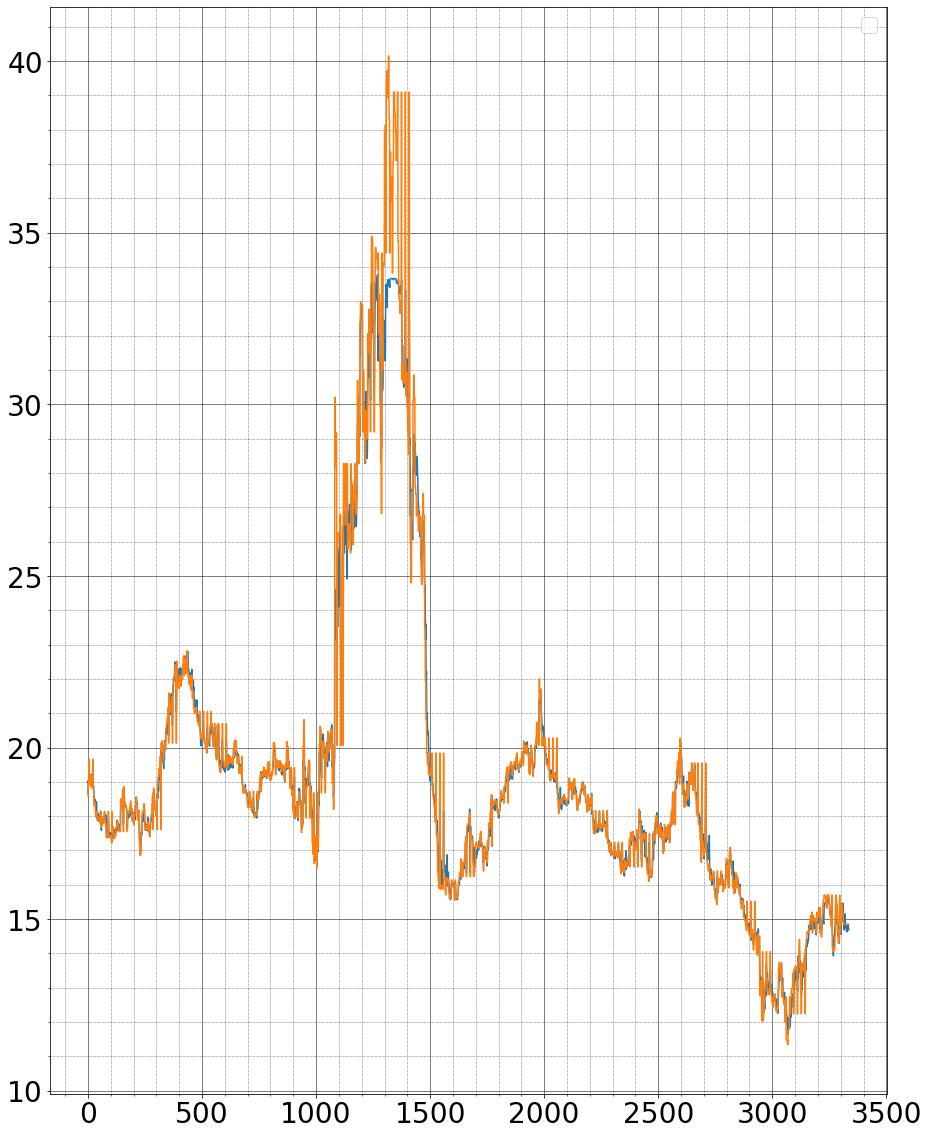

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
# lr.fit(X_train, y_train)
preds = cat.predict(X_test)
print(smape(preds, X_test['Price']))

fig = plt.figure(figsize=(15, 20))
plt.legend(prop={'size': 20})
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.grid(which='major', color='k',  linewidth = 0.5)
plt.grid(which='minor', color='k',  linestyle = ':', linewidth=0.5)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.plot(list(range(len(preds))), preds, label='preds')
plt.plot(list(range(len(preds))), X_test['Price'], label='real')

plt.savefig('graph1.jpeg', dpi=300)

In [17]:
def comp(pred,y):
    return sum(pred==y)/len(y)
  # 17:35 -- 17:44 -- 17:51
  # в среднем 9 минут на один фит
from sklearn.model_selection import KFold
kf = KFold(n_splits=20, shuffle=False)
train_proba_list = []
test_proba_list = []
train = data2.drop(['Date','Price_ND'], axis=1)
y = data2['Price_ND']
models = []
for train_val,test_val in kf.split(train):
    model = CatBoostRegressor(depth=5, silent=True)
    model.fit(train.iloc[train_val], y.iloc[train_val])
    print(comp(model.predict(train.iloc[test_val]),y.iloc[test_val]))
    models.append(model)
    train_proba_list.append(model.predict(train)) 


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [18]:
 models

In [19]:
train_preds_clf = np.vstack(train_proba_list).T
df_train_clf = pd.DataFrame(data=train_preds_clf, index=train.index)

In [26]:
from sklearn.ensemble import RandomForestRegressor
mod = RandomForestRegressor(n_estimators=5, max_depth=3)
mod.fit(df_train_clf, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
from datetime import datetime
from datetime import date
def days_between(d1, d2):
    return abs((datetime(d2.year, d2.month, d2.day) - datetime(d1.year, d1.month, d1.day)).days)

In [21]:
def bayes(mu, sigma):
    mu, sigma = mu, sigma # mean and standard deviation
    return np.random.normal(mu, sigma, 1)

In [22]:
def uni(upper, higher):
    return np.random.uniform(upper, higher)

In [23]:
bayes(0, 0.15)

array([0.07521982])

In [24]:
def predictor(date, ensemble, model, data, step=None, alpha=0.8, beta=0.6, boosty=False):
    current_raw = pd.DataFrame(data=np.zeros(shape=(1,len(data.columns))), columns=data.columns)
    date = pd.to_datetime(date)
    start_date = data.tail(1)['Date'].iloc[0]
    difference = days_between(start_date, date)
    autoreg_columns = ['Price_LD_{}'.format(i) for i in range(1, 16)]
    prob_list = []
    for i in range(0, difference):
        current_raw['Date'] = start_date + pd.Timedelta(days=i+1)
    for j in range(0,15):
        current_raw['Price_LD_{}'.format(j+1)]=data['Price'].shift(j).iloc[-1]

    current_raw['Price'] = data.tail(1)['Price_ND'].iloc[0]
    

    current_raw['moving_mean_all_autoreg'] = current_raw[autoreg_columns].mean(axis=1)
    current_raw['moving_std_all_autoreg'] = current_raw[autoreg_columns].std(axis=1)
    current_raw['moving_min_all_autoreg'] = current_raw[autoreg_columns].min(axis=1)
    current_raw['moving_max_all_autoreg'] = current_raw[autoreg_columns].max(axis=1)

    for j in range(len(ensemble)):
        prob_list.append(ensemble[j].predict(current_raw)) 
    curr_preds_clf = np.vstack(prob_list).T
    df_curr_clf = pd.DataFrame(data=curr_preds_clf, index=current_raw.index)
    value = np.mean([np.mean(df_curr_clf, axis=1),model.predict(df_curr_clf)])
    if step != None:
        if i % step == 0:
            current_raw['Price_ND'] = value + alpha * bayes(0, 10) + beta * uni(-3, 3)
        else:
            current_raw['Price_ND'] = value + bayes(0, 1)
    else:
        current_raw['Price_ND'] = value
    if boosty and i % 28 == 0:
        current_raw['Price_ND'] = value + bayes(0, 5)
    prob_list = []
    data = data.append(current_raw)
    return data

In [28]:
new = predictor('2021-12-11', models, mod, data2, step=7, alpha=0.35, beta=1.6, boosty=True)

In [29]:
new.tail(300)

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,Price_LD_16,Price_LD_17,Price_LD_18,Price_LD_19,Price_LD_20,Price_LD_21,Price_LD_22,Price_LD_23,Price_LD_24,Price_LD_25,Price_LD_26,Price_LD_27,Price_LD_28,Price_LD_29,Price_LD_30,Price_LD_31,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
10823,1988-10-18,13.23,13.700000,13.23,13.23,13.49,13.49,13.49,13.74,13.74,13.74,13.55,13.55,13.55,12.74,12.74,12.40,12.40,12.40,12.30,12.30,12.30,12.33,12.33,12.33,12.50,12.50,12.50,12.82,12.82,12.82,12.74,12.74,12.74,13.272000,4.722167e-01,12.40,13.74
10824,1988-10-17,13.70,13.700000,13.23,13.23,13.23,13.49,13.49,13.49,13.74,13.74,13.74,13.55,13.55,13.55,12.74,12.74,12.40,12.40,12.40,12.30,12.30,12.30,12.33,12.33,12.33,12.50,12.50,12.50,12.82,12.82,12.82,12.74,12.74,13.327333,4.068427e-01,12.40,13.74
10825,1988-10-17,13.70,13.700000,13.70,13.23,13.23,13.23,13.49,13.49,13.49,13.74,13.74,13.74,13.55,13.55,13.55,12.74,12.74,12.40,12.40,12.40,12.30,12.30,12.30,12.33,12.33,12.33,12.50,12.50,12.50,12.82,12.82,12.82,12.74,13.414000,3.255281e-01,12.74,13.74
10826,1988-10-17,13.70,12.740000,13.70,13.70,13.23,13.23,13.23,13.49,13.49,13.49,13.74,13.74,13.74,13.55,13.55,13.55,12.74,12.74,12.40,12.40,12.40,12.30,12.30,12.30,12.33,12.33,12.33,12.50,12.50,12.50,12.82,12.82,12.82,13.478000,2.738143e-01,12.74,13.74
10827,1988-10-16,12.74,12.740000,13.70,13.70,13.70,13.23,13.23,13.23,13.49,13.49,13.49,13.74,13.74,13.74,13.55,13.55,13.55,12.74,12.74,12.40,12.40,12.40,12.30,12.30,12.30,12.33,12.33,12.33,12.50,12.50,12.50,12.82,12.82,13.542000,1.876242e-01,13.23,13.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11118,1988-06-05,14.85,14.850000,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,15.10,15.10,15.10,15.27,15.27,15.27,15.47,15.47,15.47,14.85,14.850000,3.677408e-15,14.85,14.85
11119,1988-06-04,14.85,14.850000,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,15.10,15.10,15.10,15.27,15.27,15.27,15.47,15.47,15.47,14.850000,3.677408e-15,14.85,14.85
11120,1988-06-03,14.85,14.850000,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,15.10,15.10,15.10,15.27,15.27,15.27,15.47,15.47,14.850000,3.677408e-15,14.85,14.85
11121,1988-06-02,14.85,14.850000,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,14.85,15.10,15.10,15.10,15.27,15.27,15.27,15.47,14.850000,3.677408e-15,14.85,14.85


In [30]:
new.to_csv('main_forecast.csv')